In [26]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="kealexanderwang", project="constrained-pnns", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="kealexanderwang", project="constrained-pnns",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [27]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [39]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

# 1, 2, 3, 5 pendulums
query = {"$and": [{"tags": "data-efficiency"}, {"state": "finished"},
                  {"config.n_train": 800}]}

runs, histories = zip(*get_history(query=query))

In [40]:
#trainers = []
#for run in runs:
#    trainer, pl_model = load_model_from_run(run)
#    trainer.model = pl_model
    
#    trainers.append(trainer)
    
#for trainer in trainers:
#    trainer.test()

In [41]:
import torch

labels = []
series = []

for run in runs:
    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    body_args = tuple(run.config["body_args"])
    if len(body_args) == 0:
        body_args = ""
    elif len(body_args) == 1:
        body_args = f"({body_args[0]})"
    else:
        body_args = f"{body_args}"
    body = f"{run.config['body_class']}{body_args}"
    network_class = run.config["network_class"]

    rel_err_pred_true = ((pred_zts - true_zts).pow(2).sum((2, 3, 4)) / (pred_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
    rel_err_pert_true = ((pert_zts - true_zts).pow(2).sum((2, 3, 4)) / (pert_zts + true_zts).pow(2).sum((2,3,4))).sqrt()

    #avg_rel_err_pred = rel_err_pred_true.mean(0).numpy()
    #avg_rel_err_pert = rel_err_pert_true.mean(0).numpy()
    avg_rel_err_pred = rel_err_pred_true.numpy()
    avg_rel_err_pert = rel_err_pert_true.numpy()

    series += avg_rel_err_pred.tolist()
    labels += [(body, network_class, "avg_rel_err_pred", i) for i in range(len(avg_rel_err_pred))]
    
    series += avg_rel_err_pert.tolist()
    labels += [(body, network_class, "avg_rel_err_pert", i) for i in range(len(avg_rel_err_pert))]
    #series.append(avg_rel_err_pert)#
    #labels.append((body, network_class, "avg_rel_err_pert"))

File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists


In [42]:
#index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series"))
index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series", "Batch"))
df = pd.DataFrame(series, index=index).T

In [43]:
dt = run.config["dt"]
integration_time = run.config["integration_time"]
chunk_len = run.config["chunk_len"] * dt

In [44]:
time = pd.Series(np.arange(0, integration_time, dt))
df.index = time

In [45]:
df.head()

Body    ChainPendulum(5)                                                    \
Network               NN                                                     
Series  avg_rel_err_pred                                                     
Batch                 0         1         2         3         4         5    
0.0             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.1             0.050302  0.039608  0.090116  0.035156  0.125815  0.031622   
0.2             0.075036  0.098735  0.190983  0.072453  0.191421  0.059787   
0.3             0.078303  0.157664  0.239302  0.106545  0.206740  0.083751   
0.4             0.073182  0.199361  0.350555  0.135733  0.179320  0.101500   

Body                                             ... ChainPendulum(1)  \
Network                                          ...               NN   
Series                                           ... avg_rel_err_pert   
Batch          6         7         8         9   ...               90   
0.0      0.000000  0.000000  0.000000  0.000000  ...         0.000094   
0.1      0.009438  0.155162  0.169201  0.024047  ...         0.000097   
0.2      0.018361  0.254428  0.202327  0.047683  ...         0.000100   
0.3      0.029793  0.270404  0.220613  0.080302  ...         0.000102   
0.4      0.043222  0.281614  0.242776  0.127365  ...         0.000103   

Body                                                                           \
Network                                                                         
Series                                                                          
Batch          91        92        93        94        95        96        97   
0.0      0.000093  0.000129  0.000080  0.000015  0.000094  0.000039  0.000019   
0.1      0.000090  0.000129  0.000079  0.000014  0.000095  0.000040  0.000017   
0.2      0.000087  0.000129  0.000078  0.000014  0.000097  0.000040  0.000016   
0.3      0.000085  0.000129  0.000077  0.000015  0.000098  0.000041  0.000016   
0.4      0.000083  0.000128  0.000077  0.000016  0.000101  0.000042  0.000016   

Body                         
Network                      
Series                       
Batch          98        99  
0.0      0.000066  0.000075  
0.1      0.000066  0.000078  
0.2      0.000066  0.000083  
0.3      0.000068  0.000089  
0.4      0.000070  0.000095  

[5 rows x 2600 columns]

In [46]:
df = df.sort_index(axis=1, level="Body", ascending=True)

[Text(0, 0.5, 'Rel. Error: $||z - z_{true}||_2 / ||z + z_{true}||_2$')]

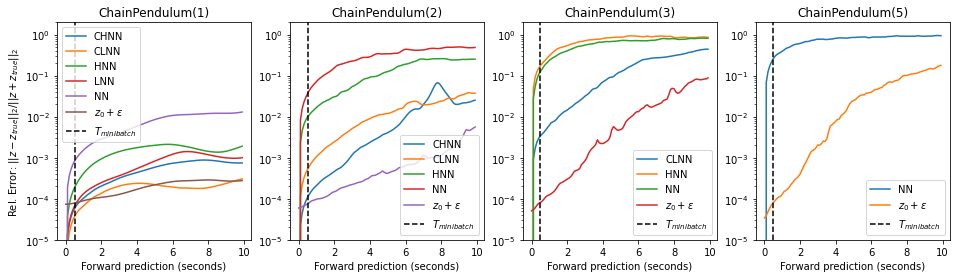

In [47]:
df_batch_avg = df.T.groupby(level=("Body", "Network", "Series")).mean().T

n_systems = len(df.columns.unique("Body"))
n_networks = len(df.columns.unique("Network"))

# TODO: uncomment when more than 1 system
fig, axes = plt.subplots(ncols=n_systems, figsize=(4 * n_systems, 4))
#fig, axes = plt.subplots(ncols=2, figsize=(4 * 2, 4))

for system, ax in zip(df.columns.unique("Body"), axes.flatten()):
    df_batch_avg.loc[:, (system, slice(None), "avg_rel_err_pred")].plot(ax=ax)
    ax.set(yscale="log",
           title=system,
           xlabel=f"Forward prediction (seconds)",
           ylim=(1e-5, 2))
    
    # Just take the perturbation curve from NN
    df_batch_avg.loc[:, (system, "NN", "avg_rel_err_pert")].plot(ax=ax)
    
    ax.axvline(chunk_len, label="Training trajectory length", color="k", linestyle="--")
    
    # TODO: remember to order this correctly if new plots are added
    ax.legend(list(df_batch_avg[system].columns.unique("Network")) + [r"$z_0 + \varepsilon$", r"$T_{minibatch}$"])
axes[0].set(ylabel=r"Rel. Error: $||z - z_{true}||_2 / ||z + z_{true}||_2$")

In [48]:
df_avg_int_err = df.apply(lambda y: np.trapz(np.log(y + 1e-8), dx=dt))
df_avg_int_err = df_avg_int_err.T.groupby(level=("Body", "Network", "Series")).mean().T
df_avg_int_err.head()

Body              Network  Series          
ChainPendulum(1)  CHNN     avg_rel_err_pert   -89.474637
                           avg_rel_err_pred   -83.901164
                  CLNN     avg_rel_err_pert   -89.130574
                           avg_rel_err_pred   -93.603446
                  HNN      avg_rel_err_pert   -90.352560
dtype: float64

[Text(0, 0, 'ChainPendulum(1)'),
 Text(0, 0, 'ChainPendulum(2)'),
 Text(0, 0, 'ChainPendulum(3)'),
 Text(0, 0, 'ChainPendulum(5)')]

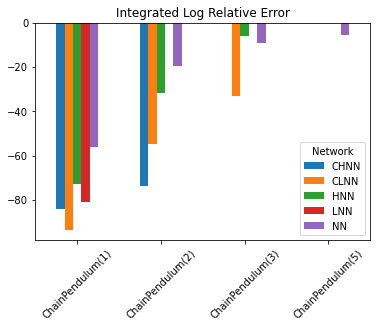

In [49]:
# TODO: uncomment when more than 1 system
#fig, axes = plt.subplots(ncols=n_systems, figsize=(4 * n_systems, 4))
fig, ax = plt.subplots()

df_avg_int_err.loc[(slice(None), slice(None), "avg_rel_err_pred")].unstack().plot(kind='bar', ax=ax)
ax.set(title="Integrated Log Relative Error", xlabel="")
ax.set_xticklabels(list(df_batch_avg.columns.unique("Body")), rotation=45)

# TODO: remember to order this correctly if new plots are added
#ax.legend(list(df_batch_avg.columns.unique("Network")))